## SVM on HOG features

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray();

import sys
import numpy as np
sys.path.append('../scripts')
import datasets

#### Cluster definition and Initialization

In [3]:
from ipyparallel import Client
client = Client()
lb_view = client.load_balanced_view()

#### Model definition

In [11]:
len(client)

65

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)
model = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
model_keyword='rbm_log2'

pipeline_params = {
    'rbm__learning_rate':np.logspace(-1, 1, 3),
    'rbm__n_iter' : [25,100],
    'rbm__n_components':[150,300],
}

In [6]:
from mmap_utils import persist_cv_splits
from sklearn.preprocessing import StandardScaler

data=datasets.load_cifar_gray()
scaler = StandardScaler()
X_train = scaler.fit_transform(data.X_train)
X_test = scaler.transform(data.X_test)
Y_train= data.y_train
Y_test= data.y_test

digits_split_filenames = persist_cv_splits(X_train, Y_train,
    name=model_keyword, random_state=4)

In [7]:
import model_selection
search = model_selection.RandomizedGridSeach(lb_view)
search.launch_for_splits(model, pipeline_params, digits_split_filenames)

Progress: 00% (000/036)

In [56]:
print(search.report())

Progress: 75% (027/036)

Rank 1: validation: 0.14232 (+/-0.00144) train: 0.13841 (+/-0.00044):
 {'rbm__n_iter': 100, 'rbm__learning_rate': 1.0, 'rbm__n_components': 150}
Rank 2: validation: 0.14152 (+/-0.00224) train: 0.13875 (+/-0.00075):
 {'rbm__n_iter': 100, 'rbm__learning_rate': 10.0, 'rbm__n_components': 150}
Rank 3: validation: 0.14128 (+/-0.00132) train: 0.13880 (+/-0.00042):
 {'rbm__n_iter': 25, 'rbm__learning_rate': 1.0, 'rbm__n_components': 300}
Rank 4: validation: 0.14125 (+/-0.00134) train: 0.13878 (+/-0.00043):
 {'rbm__n_iter': 25, 'rbm__learning_rate': 1.0, 'rbm__n_components': 150}
Rank 5: validation: 0.14125 (+/-0.00134) train: 0.13884 (+/-0.00044):
 {'rbm__n_iter': 25, 'rbm__learning_rate': 10.0, 'rbm__n_components': 300}


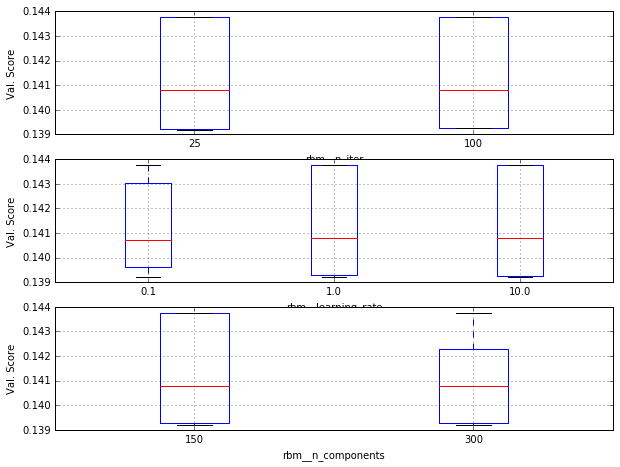

In [39]:
search.boxplot_parameters(display_train=False)

In [40]:
model2=Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

Apply the optimum parameters to Pipeline Model

In [41]:
#modfile='../models/'+model_keyword+'.pkl'
modfile='../dataset/original/dataset_rbm2.hdf5'
best_params=search.find_bests(1)[0][-1]
model2.set_params(**best_params)

Pipeline(steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=1.0, n_components=150, n_iter=100,
       random_state=0, verbose=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))])

Apply the fitting and predicting task to free cluster.

In [42]:
def pred_results(model,X_train,X_test,Y_train,Y_test,modfile):
    import h5py
    mod=model.fit(X_train,Y_train)
    dFile=h5py.File(modfile,'w')
    dFile.create_dataset('train_labels',data=Y_train)
    dFile.create_dataset('test_labels',data=Y_test)
    rbm=model.steps.pop(0)[1]
    dFile.create_dataset('train_data',data=rbm.transform(X_train))
    dFile.create_dataset('test_data',data=rbm.transform(X_test))
    dFile.close()
    return mod.predict(rbm.transform(X_test))
x=lb_view.apply(pred_results,model2,X_train,X_test,Y_train,Y_test,modfile)

In [69]:
x.ready()
#Y_pred=x.get()

False

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print 'Accuracy on complete test set: %0.2f\n\n'% (accuracy_score(Y_test, Y_pred))
print 'Classification Statistics:'
print classification_report(Y_test,Y_pred,target_names=classes)

conf = confusion_matrix(Y_test, Y_pred)
plt.imshow(conf, cmap='binary',interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45);plt.yticks(tick_marks, classes)
plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')
font = {'color':  'green','stretch':'extra-expanded','weight':0,'size': 10}
for i,j in [(n,m) for n in range(len(classes)) for m in range(len(classes))]:
    plt.text(j,i,str(conf[i,j]),font)
